In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import pandas as pd
import cv2
import xarray as xr
from utils.aux_funcs import find
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.exposure import adjust_gamma
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from matplotlib.animation import FFMpegWriter
import subprocess
import wavio

In [2]:
import matplotlib
import matplotlib.patches as mpatches

In [3]:
import matplotlib as mpl
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams.update({'font.size': 18})

In [ ]:
mpl.use('agg')
import ray
import logging
from ray.actor import ActorHandle
url = ray.init(  # address='auto',
    include_dashboard=True,
    ignore_reinit_error=True,
    logging_level=logging.ERROR,)
print(url)

In [4]:
class EphysAnimation:
    def __init__(self):
        self.start = 1496 # sec
        self.base = 'fm1'
        self.recording_path = os.path.join('/home/niell_lab/data/freely_moving_ephys/ephys_recordings/070921/J553RT/', self.base)
        self.probe = 'DB_P128-6'
        self.vidfile = '/home/niell_lab/Desktop/070921_J553RT_'+self.base+'.mp4'
        self.audfile = '/home/niell_lab/Desktop/070921_J553RT_'+self.base+'.wav'
        self.merge_mp4_name = '/home/niell_lab/Desktop/070921_J553RT_'+self.base+'_merge.mp4'
        self.has_top = (False if 'hf' in self.base else True)
        self.population_pickle_path = '/home/niell_lab/data/freely_moving_ephys/batch_files/101921/pooled_ephys_population_update_102021.pickle'
        self.session_name = '070921_J553RT_control_Rig2'
        self.fps = 60
        
    def pack_video_frames(self, video_path, dwsmpl=1):
        # open the .avi file
        vidread = cv2.VideoCapture(video_path)
        # empty array that is the target shape
        # should be number of frames x downsampled height x downsampled width
        all_frames = np.empty([int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)),
                            int(vidread.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                            int(vidread.get(cv2.CAP_PROP_FRAME_WIDTH))], dtype=np.uint8)
        # iterate through each frame
        for frame_num in tqdm(range(0,int(vidread.get(cv2.CAP_PROP_FRAME_COUNT)))):
            # read the frame in and make sure it is read in correctly
            ret, frame = vidread.read()
            if not ret:
                break
            # convert to grayyscale
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # downsample the frame by an amount specified in the config file
            sframe = cv2.resize(frame, (0,0), fx=dwsmpl, fy=dwsmpl, interpolation=cv2.INTER_NEAREST)
            # add the downsampled frame to all_frames as int8
            all_frames[frame_num,:,:] = sframe.astype(np.int8)
        return all_frames
        
    def setup(self):
        ephys_h5 = pd.read_hdf(find('*ephys*.h5', self.recording_path)[0])
        world_nc = xr.open_dataset(find('*world*.nc', self.recording_path)[0])
        eye_nc = xr.open_dataset(find('*REYE*.nc', self.recording_path)[0])
        top_nc = xr.open_dataset(find('*TOP1*.nc', self.recording_path)[0])
        eye_avi_path = find('*REYEdeinter.avi', self.recording_path)[0]
        imu_data = xr.open_dataset(find('*imu*.nc', self.recording_path)[0])
        ephysT0 = pd.read_json(find('*_ephys_merge.json', self.recording_path)[0]).iloc[0,12]
        
        print('ephys')
        ephys_pickle = pd.read_pickle(self.population_pickle_path) ### NEED PICKLE PATH
        self.pooled_ephys = ephys_pickle[ephys_pickle['session']==self.session_name] ### NEED SESSION KEY
        del ephys_pickle
        
        print('eye')
        eye_params = eye_nc.REYE_ellipse_params
        self.eyeT = eye_nc.timestamps - ephysT0
        del eye_nc
        self.eye = interp1d(self.eyeT, self.pack_video_frames(eye_avi_path).astype(np.uint8)[:,200:,120:500], axis=0, bounds_error=False)
        
        print('world')
        self.worldT = world_nc.timestamps - ephysT0
        self.world = interp1d(self.worldT, world_nc.WORLD_video.astype(np.uint8), axis=0, bounds_error=False)
        del world_nc
        
        print('top')
        self.topT = top_nc.timestamps - ephysT0
        self.top = interp1d(self.topT, top_nc.TOP1_video.astype(np.uint8), axis=0, bounds_error=False)
        del top_nc
        
        self.th = eye_params.sel(ellipse_params='theta').values
        self.longaxis = eye_params.sel(ellipse_params='longaxis')
        del eye_params
        
        self.gz = np.array(imu_data.IMU_data.sel(channel='gyro_z'))
        self.accT = ephys_h5[self.base+'_accT'].iloc[0]
        del imu_data
        
    def normal_animation(self, do_animation=True):
        fig = plt.figure(constrained_layout=True, figsize=(30,15))
        gs = fig.add_gridspec(7,4)
        ax_eyecam = fig.add_subplot(gs[0:2,0])
        ax_worldcam = fig.add_subplot(gs[0:2,1])
        ax_topcam = fig.add_subplot(gs[2:4,0])
        ax_celltype = fig.add_subplot(gs[2:4,1])
        ax_theta = fig.add_subplot(gs[4,0:2])
        ax_gyro_z = fig.add_subplot(gs[5,0:2])
        ax_radius = fig.add_subplot(gs[6,0:2])
        ax_inh_raster = fig.add_subplot(gs[0:2,2:4])
        ax_exc_raster = fig.add_subplot(gs[2:7,2:4])

        for ind, row in self.pooled_ephys.iterrows():
            if row['exc_or_inh'] == 'inh':
                ax_celltype.plot(row['norm_waveform'], 'teal')
            elif row['exc_or_inh'] == 'exc':
                ax_celltype.plot(row['norm_waveform'], 'dimgray')
        # ax_celltype.set_xlabel('msec')
        # ax_celltype.set_ylabel('millivolts')
        ax_celltype.axis('off')
        ax_celltype.annotate('inhibitory', xy=[38,-0.7], color='teal', fontsize=20)
        ax_celltype.annotate('excitatory', xy=[38,-0.9], color='dimgray', fontsize=20)

        tr = [self.start, self.start+15]
        fr = np.mean(tr)
        eye_frame = np.abs(self.eyeT-fr).argmin(dim='frame')
        world_frame = np.abs(self.worldT-fr).argmin(dim='frame')
        top_frame = np.abs(self.topT-fr).argmin(dim='frame')

        ax_eyecam.cla(); ax_eyecam.axis('off')
        ax_eyecam.imshow(self.eye(eye_frame), 'gray', vmin=0, vmax=255, aspect='equal')

        ax_worldcam.cla(); ax_worldcam.axis('off'); 
        ax_worldcam.imshow(self.world(world_frame), 'gray', vmin=0, vmax=255, aspect='equal')

        ax_topcam.cla(); ax_topcam.axis('off'); 
        ax_topcam.imshow(self.top(top_frame), 'gray', vmin=0, vmax=255, aspect='equal')

        ax_theta.cla()
        ax_theta.fontsize = 20
        ax_theta.plot(self.eyeT, np.rad2deg(self.th), color='k')
        ax_theta.set_xlim(tr[0], tr[1]); 
        ax_theta.set_ylabel('deg')
        ax_theta.set_ylim([-10,45])
        ax_theta.set_xticklabels(np.arange(0,15,2))

        ax_radius.cla()
        ax_radius.fontsize = 20
        ax_radius.plot(self.eyeT, self.longaxis/np.nanmax(self.longaxis), color='k')
        ax_radius.set_xlim(tr[0], tr[1])
        ax_radius.set_ylabel('norm. radius')
        ax_radius.set_xticklabels(np.arange(0,15,2))
        ax_radius.set_ylim([0,0.5])
        ax_radius.set_xlabel('sec')

        ax_gyro_z.cla()
        ax_gyro_z.fontsize = 20
        ax_gyro_z.plot(self.accT, self.gz, color='k')
        ax_gyro_z.set_xlim(tr[0], tr[1])
        ax_gyro_z.set_ylim(-500, 500)
        ax_gyro_z.set_ylabel('deg/s')
        ax_gyro_z.set_xticklabels(np.arange(0,15,2))

        # plot spikes
        ax_inh_raster.fontsize = 20
        if '64' in self.probe:
            sh_num = 2
        elif '128' in self.probe:
            sh_num = 4
        inh_goodcells = self.pooled_ephys[self.pooled_ephys['exc_or_inh']=='inh']
        sh0 = np.arange(0,len(inh_goodcells.index)+sh_num,sh_num)
        full_raster = np.array([]).astype(int)
        for sh in range(sh_num):
            full_raster = np.concatenate([full_raster, sh0+sh])
        # axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
        for i, ind in enumerate(inh_goodcells.index):
            i = full_raster[i]
            ax_inh_raster.vlines(inh_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25,color='teal',linewidth=0.5)

        n_units = len(inh_goodcells)
        ax_inh_raster.set_ylim(n_units, -.5)
        ax_inh_raster.set_xlim(tr[0], tr[1])
        ax_inh_raster.set_ylabel('inhibitory units')
        ax_inh_raster.spines['right'].set_visible(False)
        ax_inh_raster.spines['top'].set_visible(False)
        ax_inh_raster.spines['bottom'].set_visible(False)
        ax_inh_raster.set_xticklabels([])

        exc_goodcells = self.pooled_ephys[self.pooled_ephys['exc_or_inh']=='exc']
        sh0 = np.arange(0,len(exc_goodcells.index)+sh_num,sh_num)
        full_raster = np.array([]).astype(int)
        for sh in range(sh_num):
            full_raster = np.concatenate([full_raster, sh0+sh])
        # axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
        for i, ind in enumerate(exc_goodcells.index):
            i = full_raster[i]
            ax_exc_raster.vlines(exc_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25, color='k',linewidth=0.5)

        n_units = len(exc_goodcells)
        ax_exc_raster.set_ylim(n_units, -.5)
        ax_exc_raster.set_xlim(tr[0], tr[1])
        ax_exc_raster.set_xlabel('sec')
        ax_exc_raster.set_ylabel('excitatory units')
        ax_exc_raster.spines['right'].set_visible(False)
        ax_exc_raster.spines['top'].set_visible(False)
        ax_exc_raster.set_xticklabels(np.arange(0,15,2))

        plt.tight_layout()

        if do_animation:
            writer = FFMpegWriter(fps=30, extra_args=['-vf','scale=3200:-2'])
            with writer.saving(fig, self.vidfile, dpi=500):
                for t in np.arange(tr[0],tr[1],1/30):
                    ax_eyecam.cla(); ax_eyecam.axis('off')
                    ax_eyecam.imshow(self.eye(t),'gray',vmin=0,vmax=255,aspect='equal')
                    ax_worldcam.cla(); ax_worldcam.axis('off'); 
                    ax_worldcam.imshow(self.world(t),'gray',vmin=0,vmax=255,aspect = "equal")
                    ax_topcam.cla(); ax_topcam.axis('off')
                    ax_topcam.imshow(self.top(t).astype(np.uint8),'gray',vmin=0,vmax=255,aspect = "equal")
                    # plot line for time, then remove
                    ln1 = ax_exc_raster.vlines(t,-0.5,len(exc_goodcells),'tab:gray')
                    ln2 = ax_inh_raster.vlines(t,-0.5,len(inh_goodcells),'tab:gray')
                    ln3 = ax_theta.vlines(t,-30,45,'tab:gray')
                    ln4 = ax_radius.vlines(t,0,1,'tab:gray')
                    ln5 = ax_gyro_z.vlines(t,-500,500,'tab:gray')
                    writer.grab_frame()
                    ln1.remove(); ln2.remove(); ln3.remove(); ln4.remove(); ln5.remove()

In [ ]:
@ray.remote
def make_images(t,probe,eyeInterp,worldInterp,topInterp,eyeT,th,longaxis,accT,gz):
    start = 8
    tr = [start, start+15]
    
    fig = plt.figure(constrained_layout=True, figsize=(30,15))
    gs = fig.add_gridspec(7,4)
    ax_eyecam = fig.add_subplot(gs[0:2,0])
    ax_worldcam = fig.add_subplot(gs[0:2,1])
    ax_topcam = fig.add_subplot(gs[2:4,0])
    ax_celltype = fig.add_subplot(gs[2:4,1])
    ax_theta = fig.add_subplot(gs[5,0:2])
    ax_gyro_z = fig.add_subplot(gs[6,0:2])
    ax_radius = fig.add_subplot(gs[4,0:2])
    ax_inh_raster = fig.add_subplot(gs[0:2,2:4])
    ax_exc_raster = fig.add_subplot(gs[2:7,2:4])

    for ind, row in pooled_ephys.iterrows():
        if row['exc_or_inh'] == 'inh':
            ax_celltype.plot(row['norm_waveform'], 'teal')
        elif row['exc_or_inh'] == 'exc':
            ax_celltype.plot(row['norm_waveform'], 'dimgray')
    ax_celltype.axis('off')
    ax_celltype.annotate('inhibitory', xy=[38,-0.7], color='teal', fontsize=20)
    ax_celltype.annotate('excitatory', xy=[38,-0.9], color='dimgray', fontsize=20)
    eyeFr = np.abs(eyeT-t).argmin(dim = "frame")
    worldFr = np.abs(worldT-t).argmin(dim = "frame")
    topFr = np.abs(topT-t).argmin(dim = "frame")

    ax_eyecam.cla(); ax_eyecam.axis('off')
    ax_eyecam.imshow(eye[eyeFr].astype(np.uint8), 'gray', vmin=0, vmax=255, aspect='equal')

    ax_worldcam.cla(); ax_worldcam.axis('off')
    ax_worldcam.imshow(world[worldFr].astype(np.uint8), 'gray', vmin=0, vmax=255, aspect='equal')

    ax_topcam.cla(); ax_topcam.axis('off')
    ax_topcam.imshow(top[topFr].astype(np.uint8), 'gray', vmin=0, vmax=255, aspect='equal')

    ax_theta.cla()
    ax_theta.fontsize = 20
    ax_theta.plot(eyeT, np.rad2deg(th), color='k')
    ax_theta.set_xlim(tr[0], tr[1]); 
    ax_theta.set_ylabel('deg')
    ax_theta.set_ylim([-35,35])
    ax_theta.set_xticklabels(np.arange(0,15,2))

    ax_radius.cla()
    ax_radius.fontsize = 20
    ax_radius.plot(eyeT, longaxis/np.nanmax(longaxis), color='k')
    ax_radius.set_xlim(tr[0], tr[1])
    ax_radius.set_ylabel('norm. radius')
    ax_radius.set_xticklabels(np.arange(0,15,2))
    ax_radius.set_ylim([0.25,0.75])
    ax_radius.set_xlabel('sec')

    ax_gyro_z.cla()
    ax_gyro_z.fontsize = 20
    ax_gyro_z.plot(accT, gz, color='k')
    ax_gyro_z.set_xlim(tr[0], tr[1])
    ax_gyro_z.set_ylim(-500, 500)
    ax_gyro_z.set_ylabel('deg/s')
    ax_gyro_z.set_xticklabels(np.arange(0,15,2))

    ax_inh_raster.fontsize = 20
    if '64' in probe:
        sh_num = 2
    elif '128' in probe:
        sh_num = 4
    inh_goodcells = pooled_ephys[pooled_ephys['exc_or_inh']=='inh']
    sh0 = np.arange(0,len(inh_goodcells.index)+sh_num,sh_num)
    full_raster = np.array([]).astype(int)
    for sh in range(sh_num):
        full_raster = np.concatenate([full_raster, sh0+sh])
    for i, ind in enumerate(inh_goodcells.index):
        i = full_raster[i]
        ax_inh_raster.vlines(inh_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25,color='teal',linewidth=0.5)

    n_units = len(inh_goodcells)
    ax_inh_raster.set_ylim(n_units, -.5)
    ax_inh_raster.set_xlim(tr[0], tr[1])
    ax_inh_raster.set_ylabel('inhibitory units')
    ax_inh_raster.spines['right'].set_visible(False)
    ax_inh_raster.spines['top'].set_visible(False)
    ax_inh_raster.spines['bottom'].set_visible(False)
    ax_inh_raster.set_xticklabels([])

    exc_goodcells = pooled_ephys[pooled_ephys['exc_or_inh']=='exc']
    sh0 = np.arange(0,len(exc_goodcells.index)+sh_num,sh_num)
    full_raster = np.array([]).astype(int)
    for sh in range(sh_num):
        full_raster = np.concatenate([full_raster, sh0+sh])
    # axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
    for i, ind in enumerate(exc_goodcells.index):
        i = full_raster[i]
        ax_exc_raster.vlines(exc_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25, color='k',linewidth=0.5)

    n_units = len(exc_goodcells)
    ax_exc_raster.set_ylim(n_units, -.5)
    ax_exc_raster.set_xlim(tr[0], tr[1])
    ax_exc_raster.set_xlabel('sec')
    ax_exc_raster.set_ylabel('excitatory units')
    ax_exc_raster.spines['right'].set_visible(False)
    ax_exc_raster.spines['top'].set_visible(False)
    ax_exc_raster.set_xticklabels(np.arange(0,15,2))

    ax_theta.axvline(x=t, c='dimgray', linestyle='dotted')
    ax_gyro_z.axvline(x=t, c='dimgray', linestyle='dotted')
    ax_radius.axvline(x=t, c='dimgray', linestyle='dotted')
    ax_inh_raster.axvline(x=t, c='dimgray', linestyle='dotted')
    ax_exc_raster.axvline(x=t, c='dimgray', linestyle='dotted')

    width, height = fig.get_size_inches() * fig.get_dpi()

    fig.canvas.draw()
    images = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    plt.close()

    return images

In [5]:
ea = EphysAnimation()

In [6]:
ea.setup()

ephys
eye


100%|█████████████████████████████████| 147790/147790 [02:00<00:00, 1221.51it/s]


world
top


/tmp/ipykernel_2090701/3699027272.py:183: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


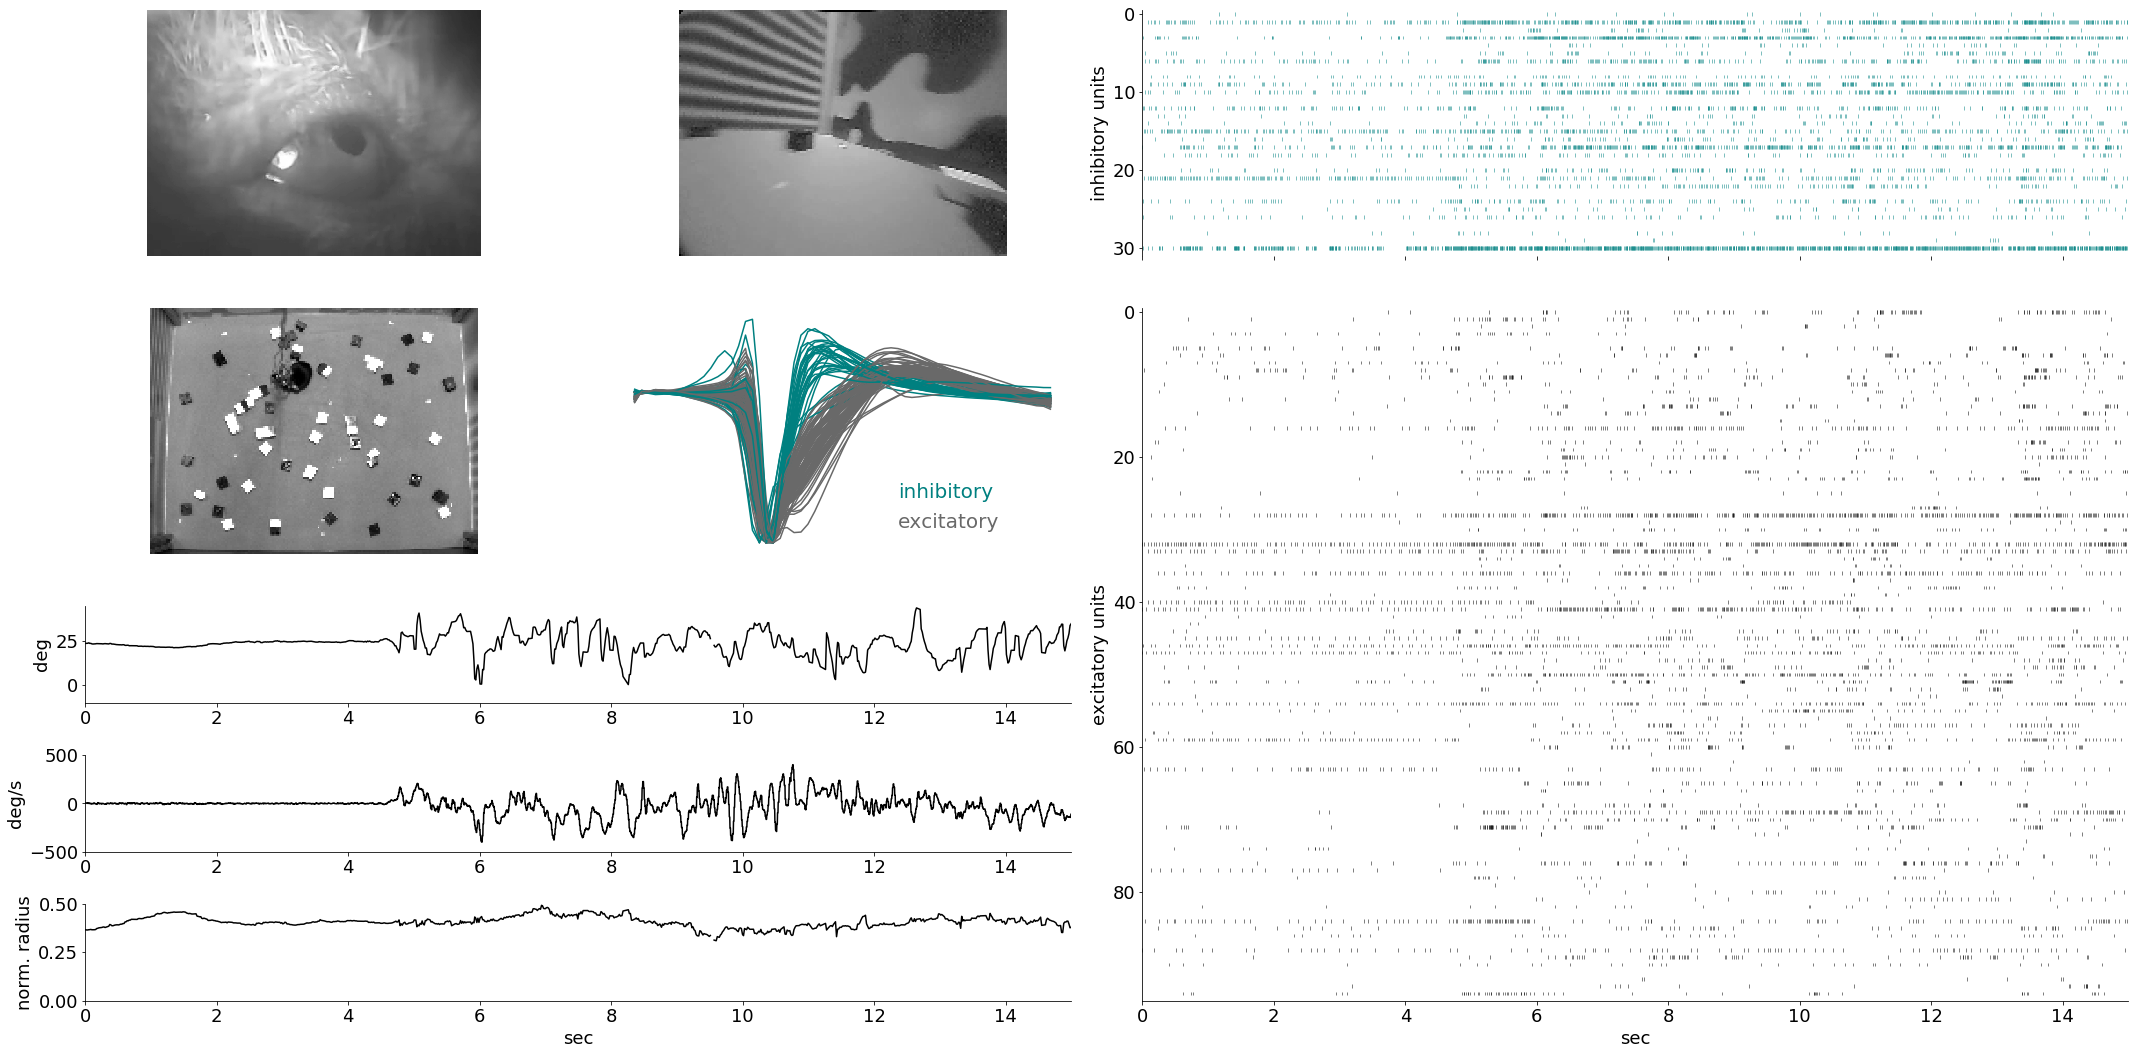

In [7]:
ea.normal_animation(do_animation=True)

In [ ]:
def normal_animation(pooled_ephys, do_animation=True):
    fig = plt.figure(constrained_layout=True, figsize=(30,15))
    gs = fig.add_gridspec(7,4)
    ax_eyecam = fig.add_subplot(gs[0:2,0])
    ax_worldcam = fig.add_subplot(gs[0:2,1])
    ax_topcam = fig.add_subplot(gs[2:4,0])
    ax_celltype = fig.add_subplot(gs[2:4,1])
    ax_theta = fig.add_subplot(gs[4,0:2])
    ax_gyro_z = fig.add_subplot(gs[5,0:2])
    ax_radius = fig.add_subplot(gs[6,0:2])
    ax_inh_raster = fig.add_subplot(gs[0:2,2:4])
    ax_exc_raster = fig.add_subplot(gs[2:7,2:4])

    for ind, row in self.pooled_ephys.iterrows():
        if row['exc_or_inh'] == 'inh':
            ax_celltype.plot(row['norm_waveform'], 'teal')
        elif row['exc_or_inh'] == 'exc':
            ax_celltype.plot(row['norm_waveform'], 'dimgray')
    # ax_celltype.set_xlabel('msec')
    # ax_celltype.set_ylabel('millivolts')
    ax_celltype.axis('off')
    ax_celltype.annotate('inhibitory', xy=[38,-0.7], color='teal', fontsize=20)
    ax_celltype.annotate('excitatory', xy=[38,-0.9], color='dimgray', fontsize=20)

    tr = [self.start, self.start+15]
    fr = np.mean(tr)
    eye_frame = np.abs(self.eyeT-fr).argmin(dim='frame')
    world_frame = np.abs(self.worldT-fr).argmin(dim='frame')
    top_frame = np.abs(self.topT-fr).argmin(dim='frame')

    ax_eyecam.cla(); ax_eyecam.axis('off')
    ax_eyecam.imshow(self.eye(eye_frame), 'gray', vmin=0, vmax=255, aspect='equal')

    ax_worldcam.cla(); ax_worldcam.axis('off'); 
    ax_worldcam.imshow(self.world(world_frame), 'gray', vmin=0, vmax=255, aspect='equal')

    ax_topcam.cla(); ax_topcam.axis('off'); 
    ax_topcam.imshow(self.top(top_frame), 'gray', vmin=0, vmax=255, aspect='equal')

    ax_theta.cla()
    ax_theta.fontsize = 20
    ax_theta.plot(self.eyeT, np.rad2deg(self.th), color='k')
    ax_theta.set_xlim(tr[0], tr[1]); 
    ax_theta.set_ylabel('deg')
    ax_theta.set_ylim([-30,30])
    ax_theta.set_xticklabels(np.arange(0,15,2))

    ax_radius.cla()
    ax_radius.fontsize = 20
    ax_radius.plot(self.eyeT, self.longaxis/np.nanmax(self.longaxis), color='k')
    ax_radius.set_xlim(tr[0], tr[1])
    ax_radius.set_ylabel('norm. radius')
    ax_radius.set_xticklabels(np.arange(0,15,2))
    ax_radius.set_ylim([0.5,1])
    ax_radius.set_xlabel('sec')

    ax_gyro_z.cla()
    ax_gyro_z.fontsize = 20
    ax_gyro_z.plot(self.accT, self.gz, color='k')
    ax_gyro_z.set_xlim(tr[0], tr[1])
    ax_gyro_z.set_ylim(-500, 500)
    ax_gyro_z.set_ylabel('deg/s')
    ax_gyro_z.set_xticklabels(np.arange(0,15,2))

    # plot spikes
    ax_inh_raster.fontsize = 20
    if '64' in self.probe:
        sh_num = 2
    elif '128' in self.probe:
        sh_num = 4
    inh_goodcells = self.pooled_ephys[self.pooled_ephys['exc_or_inh']=='inh']
    sh0 = np.arange(0,len(inh_goodcells.index)+sh_num,sh_num)
    full_raster = np.array([]).astype(int)
    for sh in range(sh_num):
        full_raster = np.concatenate([full_raster, sh0+sh])
    # axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
    for i, ind in enumerate(inh_goodcells.index):
        i = full_raster[i]
        ax_inh_raster.vlines(inh_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25,color='teal',linewidth=0.5)

    n_units = len(inh_goodcells)
    ax_inh_raster.set_ylim(n_units, -.5)
    ax_inh_raster.set_xlim(tr[0], tr[1])
    ax_inh_raster.set_ylabel('inhibitory units')
    ax_inh_raster.spines['right'].set_visible(False)
    ax_inh_raster.spines['top'].set_visible(False)
    ax_inh_raster.spines['bottom'].set_visible(False)
    ax_inh_raster.set_xticklabels([])

    exc_goodcells = self.pooled_ephys[self.pooled_ephys['exc_or_inh']=='exc']
    sh0 = np.arange(0,len(exc_goodcells.index)+sh_num,sh_num)
    full_raster = np.array([]).astype(int)
    for sh in range(sh_num):
        full_raster = np.concatenate([full_raster, sh0+sh])
    # axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
    for i, ind in enumerate(exc_goodcells.index):
        i = full_raster[i]
        ax_exc_raster.vlines(exc_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25, color='k',linewidth=0.5)

    n_units = len(exc_goodcells)
    ax_exc_raster.set_ylim(n_units, -.5)
    ax_exc_raster.set_xlim(tr[0], tr[1])
    ax_exc_raster.set_xlabel('sec')
    ax_exc_raster.set_ylabel('excitatory units')
    ax_exc_raster.spines['right'].set_visible(False)
    ax_exc_raster.spines['top'].set_visible(False)
    ax_exc_raster.set_xticklabels(np.arange(0,15,2))

    plt.tight_layout()

    if do_animation:
        writer = FFMpegWriter(fps=30, extra_args=['-vf','scale=3200:-2'])
        with writer.saving(fig, self.vidfile, dpi=500):
            for t in np.arange(tr[0],tr[1],1/30):
                ax_eyecam.cla(); ax_eyecam.axis('off')
                ax_eyecam.imshow(self.eye(t),'gray',vmin=0,vmax=255,aspect='equal')
                ax_worldcam.cla(); ax_worldcam.axis('off'); 
                ax_worldcam.imshow(self.world(t),'gray',vmin=0,vmax=255,aspect = "equal")
                ax_topcam.cla(); ax_topcam.axis('off')
                ax_topcam.imshow(self.top(t).astype(np.uint8),'gray',vmin=0,vmax=255,aspect = "equal")
                # plot line for time, then remove
                ln1 = ax_exc_raster.vlines(t,-0.5,len(exc_goodcells),'tab:gray')
                ln2 = ax_inh_raster.vlines(t,-0.5,len(inh_goodcells),'tab:gray')
                ln3 = ax_theta.vlines(t,-30,30,'tab:gray')
                ln4 = ax_radius.vlines(t,0.5,1,'tab:gray')
                ln5 = ax_gyro_z.vlines(t,-500,500,'tab:gray')
                writer.grab_frame()
                ln1.remove(); ln2.remove(); ln3.remove(); ln4.remove(); ln5.remove()

In [ ]:
start = 1496
plt.figure(figsize=(20,5))
plt.plot(ea.accT, ea.gz)
plt.xlim([start, start+15])
plt.vlines(ea.start, -700, 700)
plt.vlines(ea.start+15, -700, 700)

In [ ]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

In [ ]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
pooled_ephys = ray.put(ea.pooled_ephys.copy())
probe = ray.put(ea.probe)
eye = ray.put(ea.eye)
world = ray.put(ea.world)
top = ray.put(ea.top)
eyeT = ray.put(ea.eyeT.copy())
th = ray.put(ea.th.copy())
longaxis = ray.put(ea.longaxis.copy())
accT = ray.put(ea.accT.copy())
gz = ray.put(ea.gz.copy())

steps = np.linspace(ea.start*ea.fps, (ea.start+15)*ea.fps, 1/ea.fps)

In [ ]:
# loop over parameters appending process ids
result_ids = []
for t in range(steps):
    result_ids.append(make_images.remote(t,probe,eye,world,top,eyeT,th,longaxis,accT,gz))
results_p = ray.get(result_ids)

In [ ]:
##### Gather Data and Find Max CC Model #####
images = np.stack([results_p[i] for i in range(len(results_p))])
out = cv2.VideoWriter(ea.vidfile.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), 60, (images.shape[-2], images.shape[-3]))
for frame in tqmd(range(images.shape[0])):
    out.write(cv2.cvtColor(images[frame], cv2.COLOR_BGR2RGB))
out.release()

In [ ]:
ea.gyro_

In [ ]:
ea.add_data_to_shared_memory()

In [ ]:
ea.write_frames()

In [ ]:
ea.write_video()

In [ ]:
matplotlib.rcParams.update({'font.size': 18})
fig = plt.figure(constrained_layout=True,figsize=(30,15))
gs = fig.add_gridspec(7,4)
ax_eyecam = fig.add_subplot(gs[0:2,0])
ax_worldcam = fig.add_subplot(gs[0:2,1])
ax_topcam = fig.add_subplot(gs[2:4,0])
ax_celltype = fig.add_subplot(gs[2:4,1])
ax_theta = fig.add_subplot(gs[4,0:2])
ax_gyro_z = fig.add_subplot(gs[5,0:2])
ax_radius = fig.add_subplot(gs[6,0:2])
ax_inh_raster = fig.add_subplot(gs[0:2,2:4])
ax_exc_raster = fig.add_subplot(gs[2:7,2:4])

for ind, row in pooled_ephys.iterrows():
    if row['exc_or_inh'] == 'inh':
        ax_celltype.plot(row['norm_waveform'], 'teal')
    elif row['exc_or_inh'] == 'exc':
        ax_celltype.plot(row['norm_waveform'], 'dimgray')
# ax_celltype.set_xlabel('msec')
# ax_celltype.set_ylabel('millivolts')
ax_celltype.axis('off')
ax_celltype.annotate('inhibitory', xy=[38,-0.7], color='teal', fontsize=20)
ax_celltype.annotate('excitatory', xy=[38,-0.9], color='dimgray', fontsize=20)

tr = [start, start+15]
fr = np.mean(tr)
eye_frame = np.abs(eyeT-fr).argmin(dim='frame')
world_frame = np.abs(worldT-fr).argmin(dim='frame')
top_frame = np.abs(topT-fr).argmin(dim='frame')

ax_eyecam.cla(); ax_eyecam.axis('off')
ax_eyecam.imshow(eyeInterp(eye_frame), 'gray', vmin=0, vmax=255, aspect='equal')

ax_worldcam.cla(); ax_worldcam.axis('off'); 
ax_worldcam.imshow(worldInterp(world_frame), 'gray', vmin=0, vmax=255, aspect='equal')

ax_topcam.cla(); ax_topcam.axis('off'); 
ax_topcam.imshow(topInterp(top_frame), 'gray', vmin=0, vmax=255, aspect='equal')

ax_theta.cla()
ax_theta.fontsize = 20
ax_theta.plot(eyeT, np.rad2deg(th), color='k')
ax_theta.set_xlim(tr[0], tr[1]); 
ax_theta.set_ylabel('deg')
ax_theta.set_ylim([-30,30])
ax_theta.set_xticklabels(np.arange(0,15,2))

longaxis = eye_params.sel(ellipse_params='longaxis')
longaxis = longaxis/np.nanmax(longaxis)
ax_radius.cla()
ax_radius.fontsize = 20
ax_radius.plot(eyeT, longaxis, color='k')
ax_radius.set_xlim(tr[0], tr[1])
ax_radius.set_ylabel('norm. radius')
ax_radius.set_xticklabels(np.arange(0,15,2))
ax_radius.set_ylim([0.5,1])
ax_radius.set_xlabel('sec')

ax_gyro_z.cla()
ax_gyro_z.fontsize = 20
ax_gyro_z.plot(accT, gz, color='k')
ax_gyro_z.set_xlim(tr[0], tr[1])
ax_gyro_z.set_ylim(-500, 500)
ax_gyro_z.set_ylabel('deg/s')
ax_gyro_z.set_xticklabels(np.arange(0,15,2))

# plot spikes
ax_inh_raster.fontsize = 20
if '64' in probe:
    sh_num = 2
elif '128' in probe:
    sh_num = 4
inh_goodcells = pooled_ephys[pooled_ephys['exc_or_inh']=='inh']
sh0 = np.arange(0,len(inh_goodcells.index)+sh_num,sh_num)
full_raster = np.array([]).astype(int)
for sh in range(sh_num):
    full_raster = np.concatenate([full_raster, sh0+sh])
# axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
for i, ind in enumerate(inh_goodcells.index):
    i = full_raster[i]
    ax_inh_raster.vlines(inh_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25,color='teal',linewidth=0.5)

n_units = len(inh_goodcells)
ax_inh_raster.set_ylim(n_units, -.5)
ax_inh_raster.set_xlim(tr[0], tr[1])
ax_inh_raster.set_ylabel('inhibitory units')
ax_inh_raster.spines['right'].set_visible(False)
ax_inh_raster.spines['top'].set_visible(False)
ax_inh_raster.spines['bottom'].set_visible(False)
ax_inh_raster.set_xticklabels([])

exc_goodcells = pooled_ephys[pooled_ephys['exc_or_inh']=='exc']
sh0 = np.arange(0,len(exc_goodcells.index)+sh_num,sh_num)
full_raster = np.array([]).astype(int)
for sh in range(sh_num):
    full_raster = np.concatenate([full_raster, sh0+sh])
# axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
for i, ind in enumerate(exc_goodcells.index):
    i = full_raster[i]
    ax_exc_raster.vlines(exc_goodcells.at[ind,'fm1_spikeT'],i-0.25,i+0.25, color='k',linewidth=0.5)

n_units = len(exc_goodcells)
ax_exc_raster.set_ylim(n_units, -.5)
ax_exc_raster.set_xlim(tr[0], tr[1])
ax_exc_raster.set_xlabel('sec')
ax_exc_raster.set_ylabel('excitatory units')
ax_exc_raster.spines['right'].set_visible(False)
ax_exc_raster.spines['top'].set_visible(False)
ax_exc_raster.set_xticklabels(np.arange(0,15,2))

plt.tight_layout()

# writer = FFMpegWriter(fps=30, extra_args=['-vf','scale=800:-2'])
# with writer.saving(fig, vidfile, dpi=500):
#     for t in np.arange(tr[0],tr[1],1/30):
#         ax_eyecam.cla(); ax_eyecam.axis('off')
#         ax_eyecam.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect='equal')
#         ax_worldcam.cla(); ax_worldcam.axis('off'); 
#         ax_worldcam.imshow(worldInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
#         ax_topcam.cla(); ax_topcam.axis('off')
#         ax_topcam.imshow(topInterp(t).astype(np.uint8),'gray',vmin=0,vmax=255,aspect = "equal")
#         # plot line for time, then remove
#         ln1 = ax_exc_raster.vlines(t,-0.5,len(exc_goodcells),'tab:gray')
#         ln2 = ax_inh_raster.vlines(t,-0.5,len(inh_goodcells),'tab:gray')
#         ln3 = ax_theta.vlines(t,-30,30,'tab:gray')
#         ln4 = ax_radius.vlines(t,0.5,1,'tab:gray')
#         ln5 = ax_gyro_z.vlines(t,-500,500,'tab:gray')
#         writer.grab_frame()
#         ln1.remove(); ln2.remove(); ln3.remove(); ln4.remove(); ln5.remove()

In [ ]:
top_nc = xr.open_dataset(find('*TOP1*.nc', recording_path)[0])
topx = top_nc.TOP1_pts.sel(point_loc='tailbase_x').values
topy = top_nc.TOP1_pts.sel(point_loc='tailbase_y').values
topdX = np.diff(topx); topdY = np.diff(topy)
top_speed = np.sqrt(topdX**2, topdY**2) # speed of tailbase in topdown camera
# top_vid = np.uint8(top_nc['TOP1_video']) # read in top video

In [ ]:
def smooth_convolve(y, box_pts=10):
    """ Smooth values in an array using a convolutional window.

    Parameters:
    y (np.array): array to smooth
    box_pts (int): window size to use for convolution
    
    Returns
    y_smooth (np.array): smoothed y values
    """
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
a = top_speed
m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits

In [ ]:
start = 700
plt.figure(figsize=(30,6))
plt.plot(topT[:-1], smooth_convolve(top_speed), 'k')
plt.xlim([start, start+30])
plt.ylim([0,10])

In [ ]:
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = fig.add_gridspec(5,15)
ax_speed = fig.add_subplot(gs[0,0:10])
ax_raster = fig.add_subplot(gs[1:5,0:10])
ax_topcam = fig.add_subplot(gs[:,10:15])
start=700
tr = [start, start+30]
fr = np.mean(tr)
top_frame = np.abs(topT-fr).argmin(dim='frame')

ax_speed.plot(topT[:-1], top_speed, 'k')
ax_speed.set_xlim(tr[0], tr[1])
ax_speed.set_ylim([0,10])
ax_speed.set_xticks(np.arange(start, start+31, 5))
ax_speed.set_xticklabels(np.arange(0,31,5))

sh0 = np.arange(0,len(pooled_ephys.index)+sh_num,sh_num)
full_raster = np.array([]).astype(int)
for sh in range(sh_num):
    full_raster = np.concatenate([full_raster, sh0+sh])
# axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
for i, ind in enumerate(pooled_ephys.index):
    i = full_raster[i]
    ax_raster.vlines(pooled_ephys.at[ind,'fm1_spikeT'],i-0.25,i+0.25,color='k',linewidth=0.5)

n_units = len(pooled_ephys)
ax_raster.set_ylim(n_units, -.5)
ax_raster.set_xlim(tr[0], tr[1])
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)
ax_raster.set_xticks(np.arange(start, start+31, 5))
ax_raster.set_xticklabels(np.arange(0,31,5))

ax_topcam.cla(); ax_topcam.axis('off'); 
ax_topcam.imshow(top_vid[top_frame,:,:], 'gray', vmin=0, vmax=255, aspect='equal')

plt.tight_layout()
plt.savefig('/home/niell_lab/Desktop/topspeed.pdf')

In [ ]:
fig = plt.figure(constrained_layout=True,figsize=(15,10))
gs = fig.add_gridspec(5,15)
ax_speed = fig.add_subplot(gs[0,0:10])
ax_raster = fig.add_subplot(gs[1:5,0:10])
ax_topcam = fig.add_subplot(gs[:,10:15])
start=5
tr = [start, start+30]
fr = np.mean(tr)
top_frame = np.abs(eyeT-fr).argmin(dim='frame')

ax_speed.plot(eyeT, np.rad2deg(th), color='k')
ax_speed.set_xlim(tr[0], tr[1])
ax_speed.set_xticks(np.arange(start, start+31, 5))
ax_speed.set_xticklabels(np.arange(0,31,5))
ax_speed.set_ylim([-30,30])

sh0 = np.arange(0,len(pooled_ephys.index)+sh_num,sh_num)
full_raster = np.array([]).astype(int)
for sh in range(sh_num):
    full_raster = np.concatenate([full_raster, sh0+sh])
# axR.hlines(np.linspace(this_unit-0.25,this_unit+0.25,10), tr[0],tr[1],alpha=0.1,color='tab:blue') # this unit
for i, ind in enumerate(pooled_ephys.index):
    i = full_raster[i]
    ax_raster.vlines(pooled_ephys.at[ind,'fm1_spikeT'],i-0.25,i+0.25,color='k',linewidth=0.5)

n_units = len(pooled_ephys)
ax_raster.set_ylim(n_units, -.5)
ax_raster.set_xlim(tr[0], tr[1])
ax_raster.spines['right'].set_visible(False)
ax_raster.spines['top'].set_visible(False)
ax_raster.set_xticks(np.arange(start, start+31, 5))
ax_raster.set_xticklabels(np.arange(0,31,5))

ax_topcam.cla(); ax_topcam.axis('off');
ax_topcam.imshow(eyeInterp(eye_frame), 'gray', vmin=0, vmax=255, aspect='equal')

plt.tight_layout()
plt.savefig('/home/niell_lab/Desktop/theta.pdf')

In [ ]:
plt.plot(eyeT, np.rad2deg(th), color='k')
plt.xlim(start,start+30)